# Analysis of Utility of IPUMS data.

In [1]:
import itertools

import matplotlib.pyplot as plt

from scipy.spatial import KDTree

from statsmodels.discrete.discrete_model import Logit

from helper_functions import *

In [2]:
train_data = pd.read_csv("../Data/IPUMS/non_normalized_cleaned_ipums_data.csv")

In [3]:
sXs_mnl = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/non_normalized_gmm_and_mnl_" + str(i) + ".csv") for i in range(20)]
# ad_sXs_mnl = [pd.read_csv("../Data/SK/Synthetic Datasets/ad_gmm_and_mnl_" + str(i) + ".csv") for i in range(20)]

sXs_cart = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/non_normalized_gmm_and_cart_" + str(i) + ".csv") for i in range(20)]
# ad_sXs_cart = [pd.read_csv("../Data/SK/Synthetic Datasets/ad_gmm_and_cart_" + str(i) + ".csv") for i in range(20)]

sXs_mostly = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/non_normalized_mostly_" + str(i) + ".csv") for i in range(10)]

# Need to Update the Range Value for MOSTLY.AI Data Sets

***

## Utility Measure 1 - pMSE Ratios

In [4]:
ratios_mnl = [pmse_ratio(train_data, Y) for Y in sXs_mnl]
print(np.mean(ratios_mnl))

# ratios_ad_mnl = [pmse_ratio(train_data, Y) for Y in ad_sXs_mnl]
# print(np.mean(ratios_ad_mnl))

ratios_cart = [pmse_ratio(train_data, Y) for Y in sXs_cart]
print(np.mean(ratios_cart))

# ratios_ad_cart = [pmse_ratio(train_data, Y) for Y in ad_sXs_cart]
# print(np.mean(ratios_ad_cart))

ratios_mostly = [pmse_ratio(train_data, Y) for Y in sXs_mostly]
np.mean(ratios_mostly)

1.0546077142291321
0.9388192398784835


50.502519032368404

***

Investigate why the pMSE ratio for the MOSTLY.AI data is so high.

In [77]:
pMSE = 1/(N_synth+N_orig) * np.sum((probs[:,1] - c)**2)

In [78]:
pMSE

0.0017986508849591255

In [79]:
e_pMSE = 2*(full_X.shape[1])*(1-c)**2 * c/(N_synth+N_orig)

In [80]:
e_pMSE

3.4765064018285156e-05

In [62]:
pMSE/e_pMSE

124.07397436421095

In [37]:
synthetic_data.loc[synthetic_data.non_white==1,:].loc[synthetic_data.sex == 0,:].loc[synthetic_data.years_of_educ > 2,:]

,incwage,years_of_educ,potential_experience,non_white,sex
13515,9,13.000000,0.000000,1,0
186171,12,12.000000,2.121533,1,0
150629,14,11.000000,3.006143,1,0
188994,15,12.000000,2.142417,1,0
34072,15,12.000000,4.011532,1,0
...,...,...,...,...,...
37708,458826,12.000000,41.000178,1,0
153459,459012,17.737673,26.344768,1,0
124077,459561,17.737673,21.650436,1,0
191898,463053,17.737673,25.895795,1,0


***

Save data for plotting in R.

In [ ]:
pmse_results = pd.DataFrame({'Dataset': np.arange(1, len(ratios_mnl)+1),
                             'MNL': ratios_mnl,
                             # 'AD-MNL': ratios_ad_mnl,
                             'CART': ratios_cart,
                             # 'AD-CART': ratios_ad_cart,
                             'MOSTLY.AI': ratios_mostly})

pmse_results = pmse_results.melt(id_vars=["Dataset"], value_vars=["MNL", "CART", "MOSTLY.AI"], var_name="Type")
pmse_results.to_csv('../Results/IPUMS/non_normalized_pmse_metrics.csv', index=False)

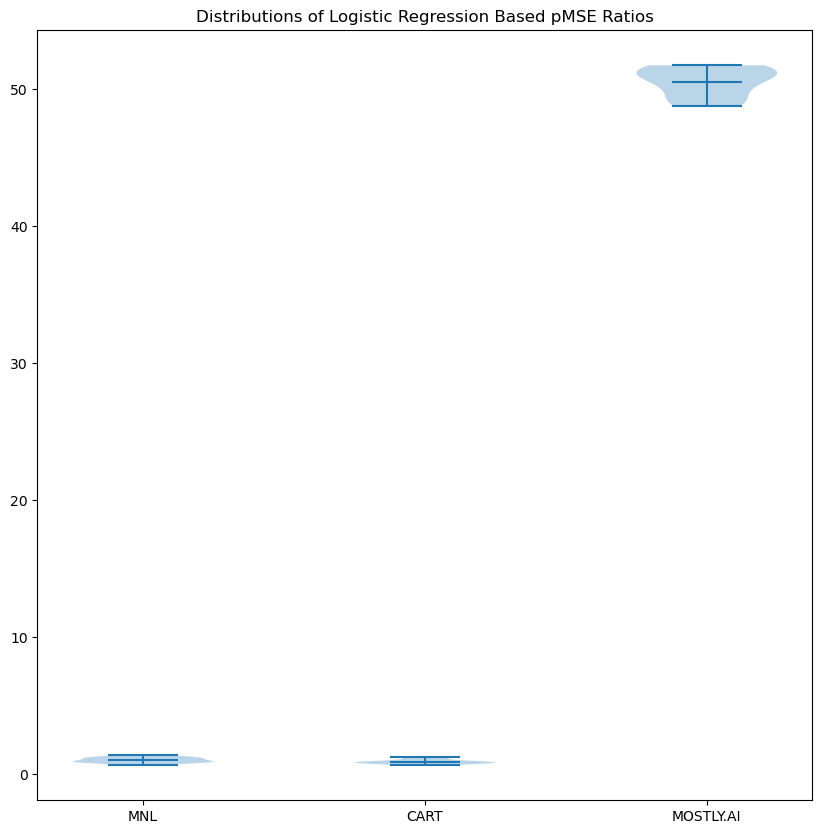

In [7]:
# Combine data
# plot_data = list([ratios_mnl, ratios_ad_mnl, ratios_cart, ratios_ad_cart, ratios_mostly])

plot_data = list([ratios_mnl, ratios_cart, ratios_mostly])

fig, ax = plt.subplots(figsize=(10,10))

# xticklabels = ["MNL", "AD-MNL", "CART", "AD-CART", "MOSTLY.AI"]
xticklabels = ["MNL", "CART", "MOSTLY.AI"]
# ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(xticklabels)

ax.violinplot(plot_data, showmeans=True)

plt.title("Distributions of Logistic Regression Based pMSE Ratios")

plt.show()

***

# Utility Metric: Analysis Specific Utility

###  * L1 distance between confidential and synthetic coefficient estimates
###  * Confidence interval ratio
###  * Sign, Significance, and Overlap (SSO)

Analysis specific utility.

Use logistic regression to predict COVID-19 deaths based on latitude and longitude, age, and sex.

Compute the model for the original data.

***

Regress log annual earnings as a function of years_of_educ, non_white, and potential experience (up to third degree polynomial).

Do the above regression for males and females separately.

In [4]:
train_data

,incwage,years_of_educ,potential_experience,non_white,sex
0,11000,16.000000,18.000000,0,1
1,38000,15.000000,23.000000,0,0
2,7000,13.000000,2.000000,0,0
3,2600,11.000000,0.000000,0,0
4,20800,12.000000,33.000000,1,0
...,...,...,...,...,...
197751,22500,16.000000,13.000000,0,0
197752,4500,16.000000,11.000000,0,1
197753,37000,17.737673,19.262327,0,0
197754,1500,15.000000,13.000000,0,1


Compute the variables for the polynomials of `potential_experience` and the target log of `incwage`.

In [5]:
def new_vars(data_sets):
    for Z in data_sets:
        Z.loc[:,'potential_experience_2'] = Z.potential_experience**2
        Z.loc[:,'potential_experience_3'] = Z.potential_experience**3
        Z.loc[:,'log_incwage'] = np.log(Z.incwage)

In [6]:
new_vars([train_data])

In [7]:
new_vars(sXs_mnl)
new_vars(sXs_cart)
new_vars(sXs_mostly)

In [8]:
sXs_mnl[0]

,incwage,years_of_educ,potential_experience,non_white,sex,potential_experience_2,potential_experience_3,log_incwage
0,29806.981185,17.735874,7.699414,0,0,59.280980,456.428826,10.302498
1,20185.004907,17.735816,3.993422,0,1,15.947419,63.684773,9.912695
2,33471.792094,17.733416,3.368039,0,1,11.343689,38.205991,10.418458
3,34805.449208,17.734569,3.698343,0,1,13.677740,50.584970,10.457529
4,30885.694386,17.737976,1.334839,0,0,1.781794,2.378408,10.338048
...,...,...,...,...,...,...,...,...
197751,57726.835886,11.999221,17.174313,0,0,294.957035,5065.684496,10.963477
197752,45352.781468,12.003633,55.656797,1,0,3097.679062,172406.895021,10.722227
197753,35060.297766,12.000646,47.860154,0,0,2290.594303,109628.195160,10.464825
197754,57982.684046,11.996054,28.724049,0,0,825.070989,23699.379510,10.967900


Split into female/male synthetic data sets.

In [9]:
sXs_mnl_female = [Z.loc[Z.sex == 1,:] for Z in sXs_mnl]
sXs_mnl_male = [Z.loc[Z.sex == 0,:] for Z in sXs_mnl]

In [10]:
sXs_cart_female = [Z.loc[Z.sex == 1,:] for Z in sXs_cart]
sXs_cart_male = [Z.loc[Z.sex == 0,:] for Z in sXs_cart]

In [11]:
sXs_mostly_female = [Z.loc[Z.sex == 1,:] for Z in sXs_mostly]
sXs_mostly_male = [Z.loc[Z.sex == 0,:] for Z in sXs_mostly]

In [12]:
train_female = train_data.loc[train_data.sex == 1,:]
train_male = train_data.loc[train_data.sex == 0,:]

In [13]:
ols_train_female = ols_param_fetcher(data=train_female, y='log_incwage', X=['years_of_educ', 'non_white', 'potential_experience', 'potential_experience_2', 'potential_experience_3'])

In [14]:
ols_train_male = ols_param_fetcher(data=train_male, y='log_incwage', X=['years_of_educ', 'non_white', 'potential_experience', 'potential_experience_2', 'potential_experience_3'])

In [15]:
ols_train_female

{'params': const                     6.185850
 years_of_educ             0.161283
 non_white                -0.015301
 potential_experience      0.153996
 potential_experience_2   -0.005422
 potential_experience_3    0.000058
 dtype: float64,
 'l_var': array([4.21162561e-04, 1.94141687e-06, 8.11209507e-05, 3.71984637e-06,
        1.05403807e-08, 2.28290018e-12]),
 'CI':           0         1
 0  6.145626  6.226073
 1  0.158552  0.164014
 2 -0.032954  0.002352
 3  0.150215  0.157776
 4 -0.005623 -0.005221
 5  0.000055  0.000061}

In [16]:
ols_train_male

{'params': const                     6.608703
 years_of_educ             0.136343
 non_white                -0.195098
 potential_experience      0.218667
 potential_experience_2   -0.007680
 potential_experience_3    0.000082
 dtype: float64,
 'l_var': array([2.28497237e-04, 9.74753129e-07, 6.11123627e-05, 2.49616254e-06,
        6.74568404e-09, 1.42161020e-12]),
 'CI':           0         1
 0  6.579076  6.638330
 1  0.134408  0.138278
 2 -0.210420 -0.179776
 3  0.215571  0.221764
 4 -0.007841 -0.007519
 5  0.000080  0.000085}

Results for female regression.

In [17]:
all_data_types = ['Original', 'MNL', 'CART', 'MOSTLY.AI']
female_all_data = [[train_female], sXs_mnl_female, sXs_cart_female, sXs_mostly_female]

In [18]:
female_all_l1_results = pd.DataFrame()
female_all_p_and_i_results = pd.DataFrame()

for i, j in enumerate(female_all_data):
    current_l1_results, current_p_and_i_results = coef_L1_calc(original_data=train_female, synthetic_datasets=j, synthetic_data_type=all_data_types[i],
                                                               target_variable='log_incwage', 
                                                               exog_variables=['years_of_educ', 'non_white', 'potential_experience', 'potential_experience_2', 'potential_experience_3'],
                                                               param_names=['Intercept', 'Years of Education', 'Non-white', 'Potential Experience', 'Potential Experience^2', 'Potential Experience^3'])

    female_all_l1_results = pd.concat([female_all_l1_results, current_l1_results.reset_index()], axis=0)
    female_all_p_and_i_results = pd.concat([female_all_p_and_i_results, current_p_and_i_results])

In [19]:
female_all_l1_results

,index,Intercept,Years of Education,Non-white,Potential Experience,Potential Experience^2,Potential Experience^3,Data Type,Measure
0,0,0.0,0.0,0.0,0.0,0.0,0.0,Original,L1 Distance
1,0,1.0,1.0,1.0,1.0,1.0,1.0,Original,CI Ratio
2,0,1.0,1.0,1.0,1.0,1.0,1.0,Original,Sign Match
3,0,1.0,1.0,1.0,1.0,1.0,1.0,Original,Significance Match
4,0,1.0,1.0,1.0,1.0,1.0,1.0,Original,CI Overlap
...,...,...,...,...,...,...,...,...,...
45,5,0.0,0.0,0.0,1.0,1.0,0.0,MOSTLY.AI,CI Overlap
46,6,0.0,0.0,1.0,1.0,1.0,1.0,MOSTLY.AI,CI Overlap
47,7,0.0,0.0,1.0,1.0,1.0,1.0,MOSTLY.AI,CI Overlap
48,8,0.0,0.0,1.0,1.0,1.0,1.0,MOSTLY.AI,CI Overlap


In [20]:
female_all_p_and_i_results

,Parameter,Point Estimate,Lower Bound,Upper Bound,Type,index
0,const,6.185850,6.145626,6.226073,Original,0
1,years_of_educ,0.161283,0.158552,0.164014,Original,0
2,non_white,-0.015301,-0.032954,0.002352,Original,0
3,potential_experience,0.153996,0.150215,0.157776,Original,0
4,potential_experience_2,-0.005422,-0.005623,-0.005221,Original,0
...,...,...,...,...,...,...
55,years_of_educ,0.143792,0.141043,0.146541,MOSTLY.AI,9
56,non_white,-0.040742,-0.058954,-0.022531,MOSTLY.AI,9
57,potential_experience,0.152949,0.149140,0.156758,MOSTLY.AI,9
58,potential_experience_2,-0.005257,-0.005454,-0.005060,MOSTLY.AI,9


In [21]:
female_all_l1_results = female_all_l1_results.melt(id_vars=["Data Type", "Measure", "index"], 
                                                   value_vars=['Intercept', 'Years of Education', 'Non-white', 'Potential Experience', 'Potential Experience^2', 'Potential Experience^3'], 
                                                   var_name="Variable")

In [22]:
female_all_l1_results

,Data Type,Measure,index,Variable,value
0,Original,L1 Distance,0,Intercept,0.0
1,Original,CI Ratio,0,Intercept,1.0
2,Original,Sign Match,0,Intercept,1.0
3,Original,Significance Match,0,Intercept,1.0
4,Original,CI Overlap,0,Intercept,1.0
...,...,...,...,...,...
1525,MOSTLY.AI,CI Overlap,5,Potential Experience^3,0.0
1526,MOSTLY.AI,CI Overlap,6,Potential Experience^3,1.0
1527,MOSTLY.AI,CI Overlap,7,Potential Experience^3,1.0
1528,MOSTLY.AI,CI Overlap,8,Potential Experience^3,1.0


Save data for analysis and plotting in R.

In [23]:
female_all_l1_results.to_csv('../Results/IPUMS/non_normalized_female_analysis_specific.csv', index=False)

In [24]:
female_all_p_and_i_results.to_csv('../Results/IPUMS/non_normalized_female_point_estimates_and_intervals.csv', index=False)

***

Results for male regression.

In [25]:
male_all_data = [[train_male], sXs_mnl_male, sXs_cart_male, sXs_mostly_male]

In [26]:
male_all_l1_results = pd.DataFrame()
male_all_p_and_i_results = pd.DataFrame()

for i, j in enumerate(male_all_data):
    current_l1_results, current_p_and_i_results = coef_L1_calc(original_data=train_male, synthetic_datasets=j, synthetic_data_type=all_data_types[i],
                                                               target_variable='log_incwage', 
                                                               exog_variables=['years_of_educ', 'non_white', 'potential_experience', 'potential_experience_2', 'potential_experience_3'],
                                                               param_names=['Intercept', 'Years of Education', 'Non-white', 'Potential Experience', 'Potential Experience^2', 'Potential Experience^3'])

    male_all_l1_results = pd.concat([male_all_l1_results, current_l1_results.reset_index()], axis=0)
    male_all_p_and_i_results = pd.concat([male_all_p_and_i_results, current_p_and_i_results])

In [27]:
male_all_l1_results = male_all_l1_results.melt(id_vars=["Data Type", "Measure", "index"], 
                                               value_vars=['Intercept', 'Years of Education', 'Non-white', 'Potential Experience', 'Potential Experience^2', 'Potential Experience^3'], 
                                               var_name="Variable")

In [28]:
male_all_l1_results.to_csv('../Results/IPUMS/non_normalized_male_analysis_specific.csv', index=False)

In [29]:
male_all_p_and_i_results.to_csv('../Results/IPUMS/non_normalized_male_point_estimates_and_intervals.csv', index=False)